In [15]:
import numpy as np
import pandas as pd

In [16]:
df = pd.read_csv('sequence_with_lag_features_cancel_out.csv')  
df['is_holiday'] = df['is_holiday'].replace({False: 0, True: 1})
df['1y_holiday_diff'] = df['1y_holiday_diff'].fillna(0)
df['lag_1_spending'] = df['lag_1_spending'].fillna(0)
df['lag_2_spending'] = df['lag_2_spending'].fillna(0)
df['lag_3_spending'] = df['lag_3_spending'].fillna(0)
df['lag_5_spending'] = df['lag_5_spending'].fillna(0)
df['lag_6_spending'] = df['lag_6_spending'].fillna(0)
df['lag_7_spending'] = df['lag_7_spending'].fillna(0)
df['lag_9_spending'] = df['lag_9_spending'].fillna(0)
df['lag_11_spending'] = df['lag_11_spending'].fillna(0)
df['lag_12_spending'] = df['lag_12_spending'].fillna(0)
df.head(10)

C:\Users\Suzreal\AppData\Local\Temp\ipykernel_18088\3160989619.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_holiday'] = df['is_holiday'].replace({False: 0, True: 1})


,user_id,year_month,txn_count_prev,total_expense_prev,mean_amount,user_gender,user_current_age,user_yearly_income,user_per_capita_income,user_credit_score,...,lag_2_spending,lag_3_spending,lag_5_spending,lag_6_spending,lag_7_spending,lag_9_spending,lag_11_spending,lag_12_spending,1y_holiday_diff,is_holiday
0,0,2015-01-01,128.0,6185.2,53.0,0,33,59613.0,29237.0,763,...,3859.24,6766.18,4266.63,6777.58,6604.68,5055.62,5109.56,6169.59,-1252.72,1
1,0,2015-02-01,99.0,5249.9,49.2,0,33,59613.0,29237.0,763,...,7091.15,3859.24,5642.49,4266.63,6777.58,7068.70,4600.44,5109.56,-739.90,1
2,0,2015-03-01,86.0,4229.7,45.5,0,33,59613.0,29237.0,763,...,4916.87,7091.15,6766.18,5642.49,4266.63,6604.68,5055.62,4600.44,0.00,0
3,0,2015-04-01,101.0,4595.4,47.8,0,33,59613.0,29237.0,763,...,4369.66,4916.87,3859.24,6766.18,5642.49,6777.58,7068.70,5055.62,0.00,0
4,0,2015-05-01,96.0,4586.5,50.6,0,33,59613.0,29237.0,763,...,5495.42,4369.66,7091.15,3859.24,6766.18,4266.63,6604.68,7068.70,-1420.57,1
5,0,2015-06-01,116.0,5864.1,57.6,0,33,59613.0,29237.0,763,...,4938.54,5495.42,4916.87,7091.15,3859.24,5642.49,6777.58,6604.68,0.00,0
6,0,2015-07-01,106.0,6104.9,59.8,0,33,59613.0,29237.0,763,...,5648.13,4938.54,4369.66,4916.87,7091.15,6766.18,4266.63,6777.58,-1133.53,1
7,0,2015-08-01,92.0,5504.1,48.8,0,33,59613.0,29237.0,763,...,5886.93,5648.13,5495.42,4369.66,4916.87,3859.24,5642.49,4266.63,0.00,0
8,0,2015-09-01,103.0,5029.5,56.7,0,33,59613.0,29237.0,763,...,5644.05,5886.93,4938.54,5495.42,4369.66,7091.15,6766.18,5642.49,67.42,1
9,0,2015-10-01,94.0,5329.9,58.9,0,33,59613.0,29237.0,763,...,5029.51,5644.05,5648.13,4938.54,5495.42,4916.87,3859.24,6766.18,-495.02,1


In [17]:
df['year_month'] = pd.to_datetime(df['year_month'])
df = df.rename(columns={'total_expense_prev': 'total_spending'})  

'''
The new setup for datasets and dataloaders
'''

train_end = pd.Timestamp('2017-12-31')
val_end = pd.Timestamp('2018-12-31')
test_end = pd.Timestamp('2019-09-30')

train_mask = df['year_month'] <= train_end
val_mask = (df['year_month'] > train_end) & (df['year_month'] <= val_end)
test_mask = (df['year_month'] > val_end) & (df['year_month'] <= test_end)

train_df = df.loc[train_mask].copy()
val_df = df.loc[val_mask].copy()
test_df = df.loc[test_mask].copy()


print(len(train_df), len(val_df), len(test_df))


43305 14454 10852


In [18]:
from sklearn.preprocessing import StandardScaler

num_cols = [
    "user_yearly_income",
    "user_per_capita_income",
    "user_credit_score",
    "user_total_debt",
    "income_per_card",
    "mean_amount",
]
# --- normalize ---
scaler = StandardScaler()
scaler.fit(train_df[num_cols])

df_scaled = df.copy()
df_scaled[num_cols] = scaler.transform(df_scaled[num_cols])

In [19]:
import torch
from torch.utils.data import Dataset

class TransactionDataset(Dataset):
    def __init__(self, df, feature_cols, user_col='user_id', date_col='year_month',
                 target_col='total_spending', window_size=12,
                 target_start=None, target_end=None):
        self.feature_cols = feature_cols
        self.user_col = user_col
        self.date_col = date_col
        self.target_col = target_col
        self.window_size = window_size
        self.samples = []


        ts = pd.to_datetime(target_start) if target_start is not None else None
        te = pd.to_datetime(target_end)   if target_end   is not None else None
        if ts is None: ts = df[date_col].min()
        if te is None: te = df[date_col].max()


        for _, g in df.groupby(user_col):
            '''
            We use previous 12 months of data to predict the target month, even if the history 
            crosses the train/val/test boundaries
            '''
            g = g.sort_values(date_col).reset_index(drop=True)
            Xmat = g[self.feature_cols].to_numpy(dtype=float)
            yvec = g[self.target_col].to_numpy(dtype=float)
            months = g[date_col].to_numpy()

            for i in range(window_size, len(g)):
                t_month = months[i]
                if t_month < ts or t_month > te:
                    continue
                X = Xmat[i-window_size:i]
                y = float(yvec[i])
                self.samples.append((X, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        X, y = self.samples[idx]
        return (
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32)
        )


In [20]:
import torch
import torch.nn as nn

class LSTMAmountPredictor(nn.Module):
    def __init__(self, num_features, hidden_dim=128, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=num_features,   
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [batch, seq_len, num_features]
        out, _ = self.lstm(x)
        last_out = out[:, -1, :]  # [batch, hidden_dim]
        y_pred = self.fc(last_out)  # [batch, 1]
        return y_pred.squeeze(-1)


In [21]:
feature_cols = [
    "txn_count_prev",
    "mean_amount",
    "user_gender",
    "user_current_age",
    "user_yearly_income",
    "user_per_capita_income",
    "user_credit_score",
    "user_total_debt",
    "user_birth_month",
    "card_num_cards_issued",
    "user_latitude",
    "user_longitude",
    "year_to_retirement",
    "debt_to_yearly_income_ratio",
    "income_per_card",
    "multi_card_user",
    "income_utilization_ratio",
    "credit_utilization_ratio",
    "oldest_card_age_years",
    "percentage_prev_monthly_expense_as_yearly",
    "percentage_prev_monthly_expense_as_capita",
    "1y_holiday_diff",
    "is_holiday",
]


'''
The new setup for datasets and dataloaders
'''
train_target_start= df['year_month'].min() + pd.offsets.MonthBegin(0)
train_target_end= train_end
val_target_start= train_end + pd.offsets.Day(1)
val_target_end= val_end
test_target_start= val_end + pd.offsets.Day(1)
test_target_end= test_end

In [22]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

num_features = len(feature_cols)
model = LSTMAmountPredictor(num_features=num_features, hidden_dim=128, num_layers=2)
# hyperparam
BATCH_SIZE = 128
EPOCHS = 30
LR = 1e-3
PATIENCE = 6   

'''
The new setup for datasets and dataloaders
'''
train_dataset = TransactionDataset(
    df=df_scaled, feature_cols=feature_cols, window_size=12,
    target_start=train_target_start, target_end=train_target_end,
    target_col='total_spending'
)
val_dataset = TransactionDataset(
    df=df_scaled, feature_cols=feature_cols, window_size=12,
    target_start=val_target_start, target_end=val_target_end,
    target_col='total_spending'
)
test_dataset = TransactionDataset(
    df=df_scaled, feature_cols=feature_cols, window_size=12,
    target_start=test_target_start, target_end=test_target_end,
    target_col='total_spending'
)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

best_val_loss = np.inf
patience_counter = 0


Epoch 1/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 479.82it/s]



📘 Epoch 01 | Train Loss: 21587511.555556 | Val Loss: 21308265.867257 | test Loss: 21094800.517647
✅ Saved new best model (val_loss=21308265.867257)


Epoch 2/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 525.77it/s]



📘 Epoch 02 | Train Loss: 21354700.351111 | Val Loss: 21080798.163717 | test Loss: 20867999.494118
✅ Saved new best model (val_loss=21080798.163717)


Epoch 3/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 442.44it/s]



📘 Epoch 03 | Train Loss: 21121302.431111 | Val Loss: 20858459.530973 | test Loss: 20646316.911765
✅ Saved new best model (val_loss=20858459.530973)


Epoch 4/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 440.59it/s]



📘 Epoch 04 | Train Loss: 20906995.231111 | Val Loss: 20639441.690265 | test Loss: 20427949.941176
✅ Saved new best model (val_loss=20639441.690265)


Epoch 5/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 489.89it/s]



📘 Epoch 05 | Train Loss: 20684503.964444 | Val Loss: 20423203.513274 | test Loss: 20212359.352941
✅ Saved new best model (val_loss=20423203.513274)


Epoch 6/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 483.71it/s]



📘 Epoch 06 | Train Loss: 20469623.275556 | Val Loss: 20209443.955752 | test Loss: 19999244.917647
✅ Saved new best model (val_loss=20209443.955752)


Epoch 7/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 467.00it/s]



📘 Epoch 07 | Train Loss: 20249837.106667 | Val Loss: 19997955.079646 | test Loss: 19788399.058824
✅ Saved new best model (val_loss=19997955.079646)


Epoch 8/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 463.44it/s]



📘 Epoch 08 | Train Loss: 20040819.048889 | Val Loss: 19788879.376106 | test Loss: 19579963.888235
✅ Saved new best model (val_loss=19788879.376106)


Epoch 9/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 460.13it/s]



📘 Epoch 09 | Train Loss: 19837419.662222 | Val Loss: 19581768.146018 | test Loss: 19373492.329412
✅ Saved new best model (val_loss=19581768.146018)


Epoch 10/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 464.19it/s]



📘 Epoch 10 | Train Loss: 19627998.613333 | Val Loss: 19376963.384956 | test Loss: 19169324.676471
✅ Saved new best model (val_loss=19376963.384956)


Epoch 11/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 467.97it/s]



📘 Epoch 11 | Train Loss: 19421923.515556 | Val Loss: 19173875.752212 | test Loss: 18966874.164706
✅ Saved new best model (val_loss=19173875.752212)


Epoch 12/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 481.07it/s]



📘 Epoch 12 | Train Loss: 19225151.097778 | Val Loss: 18972675.026549 | test Loss: 18766309.594118
✅ Saved new best model (val_loss=18972675.026549)


Epoch 13/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 467.67it/s]



📘 Epoch 13 | Train Loss: 19019581.640000 | Val Loss: 18773497.460177 | test Loss: 18567766.817647
✅ Saved new best model (val_loss=18773497.460177)


Epoch 14/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 513.19it/s]



📘 Epoch 14 | Train Loss: 18821342.031111 | Val Loss: 18575953.261062 | test Loss: 18370857.311765
✅ Saved new best model (val_loss=18575953.261062)


Epoch 15/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 481.95it/s]



📘 Epoch 15 | Train Loss: 18623763.813333 | Val Loss: 18380424.075221 | test Loss: 18175961.058824
✅ Saved new best model (val_loss=18380424.075221)


Epoch 16/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 466.21it/s]



📘 Epoch 16 | Train Loss: 18428898.360000 | Val Loss: 18186766.619469 | test Loss: 17982936.064706
✅ Saved new best model (val_loss=18186766.619469)


Epoch 17/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 422.14it/s]



📘 Epoch 17 | Train Loss: 18235407.164444 | Val Loss: 17994645.380531 | test Loss: 17791447.088235
✅ Saved new best model (val_loss=17994645.380531)


Epoch 18/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 473.16it/s]



📘 Epoch 18 | Train Loss: 18040596.346667 | Val Loss: 17804489.146018 | test Loss: 17601921.911765
✅ Saved new best model (val_loss=17804489.146018)


Epoch 19/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 457.59it/s]



📘 Epoch 19 | Train Loss: 17851938.142222 | Val Loss: 17615622.110619 | test Loss: 17413686.694118
✅ Saved new best model (val_loss=17615622.110619)


Epoch 20/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 453.40it/s]



📘 Epoch 20 | Train Loss: 17657892.782222 | Val Loss: 17428830.110619 | test Loss: 17227525.076471
✅ Saved new best model (val_loss=17428830.110619)


Epoch 21/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 494.78it/s]



📘 Epoch 21 | Train Loss: 17475733.724444 | Val Loss: 17243716.238938 | test Loss: 17043040.764706
✅ Saved new best model (val_loss=17243716.238938)


Epoch 22/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 467.83it/s]



📘 Epoch 22 | Train Loss: 17289593.191111 | Val Loss: 17060369.199115 | test Loss: 16860323.211765
✅ Saved new best model (val_loss=17060369.199115)


Epoch 23/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 455.47it/s]



📘 Epoch 23 | Train Loss: 17112463.777778 | Val Loss: 16878415.544248 | test Loss: 16678999.176471
✅ Saved new best model (val_loss=16878415.544248)


Epoch 24/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 487.46it/s]



📘 Epoch 24 | Train Loss: 16928144.017778 | Val Loss: 16698166.615044 | test Loss: 16499379.394118
✅ Saved new best model (val_loss=16698166.615044)


Epoch 25/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 459.98it/s]



📘 Epoch 25 | Train Loss: 16744803.133333 | Val Loss: 16519509.283186 | test Loss: 16321351.305882
✅ Saved new best model (val_loss=16519509.283186)


Epoch 26/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 463.17it/s]



📘 Epoch 26 | Train Loss: 16566359.995556 | Val Loss: 16342680.780973 | test Loss: 16145151.058824
✅ Saved new best model (val_loss=16342680.780973)


Epoch 27/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 495.14it/s]



📘 Epoch 27 | Train Loss: 16393764.031111 | Val Loss: 16167432.207965 | test Loss: 15970531.158824
✅ Saved new best model (val_loss=16167432.207965)


Epoch 28/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 459.53it/s]



📘 Epoch 28 | Train Loss: 16215907.902222 | Val Loss: 15993909.108407 | test Loss: 15797637.047059
✅ Saved new best model (val_loss=15993909.108407)


Epoch 29/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 467.04it/s]



📘 Epoch 29 | Train Loss: 16041948.942222 | Val Loss: 15821787.632743 | test Loss: 15626143.641176
✅ Saved new best model (val_loss=15821787.632743)


Epoch 30/30 [Test]: 100%|██████████| 85/85 [00:00<00:00, 451.10it/s]


📘 Epoch 30 | Train Loss: 15872371.173333 | Val Loss: 15651375.172566 | test Loss: 15456358.617647
✅ Saved new best model (val_loss=15651375.172566)


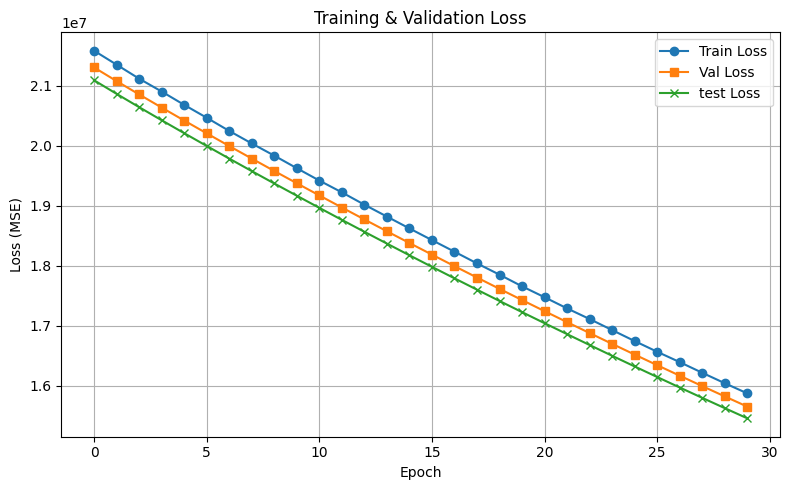

In [23]:
train_history = {"train_loss": [], "val_loss": [],"test_loss":[]}
for epoch in range(EPOCHS):
    model.train()
    train_losses = []
    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        preds = model(X).squeeze()  # (batch,)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for X, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            X, y = X.to(device), y.to(device)
            preds = model(X).squeeze()
            loss = criterion(preds, y)
            val_losses.append(loss.item())

    avg_val_loss = np.mean(val_losses)
    test_losses = []
    with torch.no_grad():
        for X, y in tqdm(test_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Test]"):
            X, y = X.to(device), y.to(device)
            preds = model(X).squeeze()
            loss = criterion(preds, y)
            test_losses.append(loss.item())

    avg_test_loss = np.mean(test_losses)

    train_history["train_loss"].append(avg_train_loss)
    train_history["val_loss"].append(avg_val_loss)
    train_history["test_loss"].append(avg_test_loss)

    print(f"\n📘 Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | test Loss: {avg_test_loss:.6f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_lstm_model.pt")
        print(f"✅ Saved new best model (val_loss={best_val_loss:.6f})")
    else:
        patience_counter += 1
        print(f" No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("⏹️ Early stopping triggered")
            break


plt.figure(figsize=(8, 5))
plt.plot(train_history["train_loss"], label="Train Loss", marker="o")
plt.plot(train_history["val_loss"], label="Val Loss", marker="s")
plt.plot(train_history["test_loss"], label="test Loss", marker='x')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
import torch
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

model.load_state_dict(torch.load("best_lstm_model.pt"))
model.to(device)
model.eval()

def evaluate_model(loader, model, device):
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).squeeze()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true, y_pred = np.array(y_true), np.array(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  

    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape}


val_metrics = evaluate_model(val_loader, model, device)
print("\n📊 Validation Set Metrics:")
for k, v in val_metrics.items():
    print(f"  {k}: {v:.6f}")

test_metrics = evaluate_model(test_loader, model, device)
print("\n📊 Test Set Metrics:")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.6f}")


C:\Users\Suzreal\AppData\Local\Temp\ipykernel_18088\2330783964.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_lstm_model.pt"))



📊 Validation Set Metrics:
  MAE: 3054.837402
  MSE: 15636923.000000
  RMSE: 3954.354980
  MAPE: 69.866025

📊 Test Set Metrics:
  MAE: 3040.802979
  MSE: 15416172.000000
  RMSE: 3926.343262
  MAPE: 69.650042


In [25]:
print(df['total_spending'].max())
print(df['total_spending'].min())
print(df['total_spending'].median())
print(df['total_spending'].mean())

28507.3
0.0
3250.8500000000004
3900.494294840576


C:\Users\Suzreal\AppData\Local\Temp\ipykernel_18088\2676961632.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Relative Importance", y="Feature", data=ig_importance_df.head(20), palette="magma")


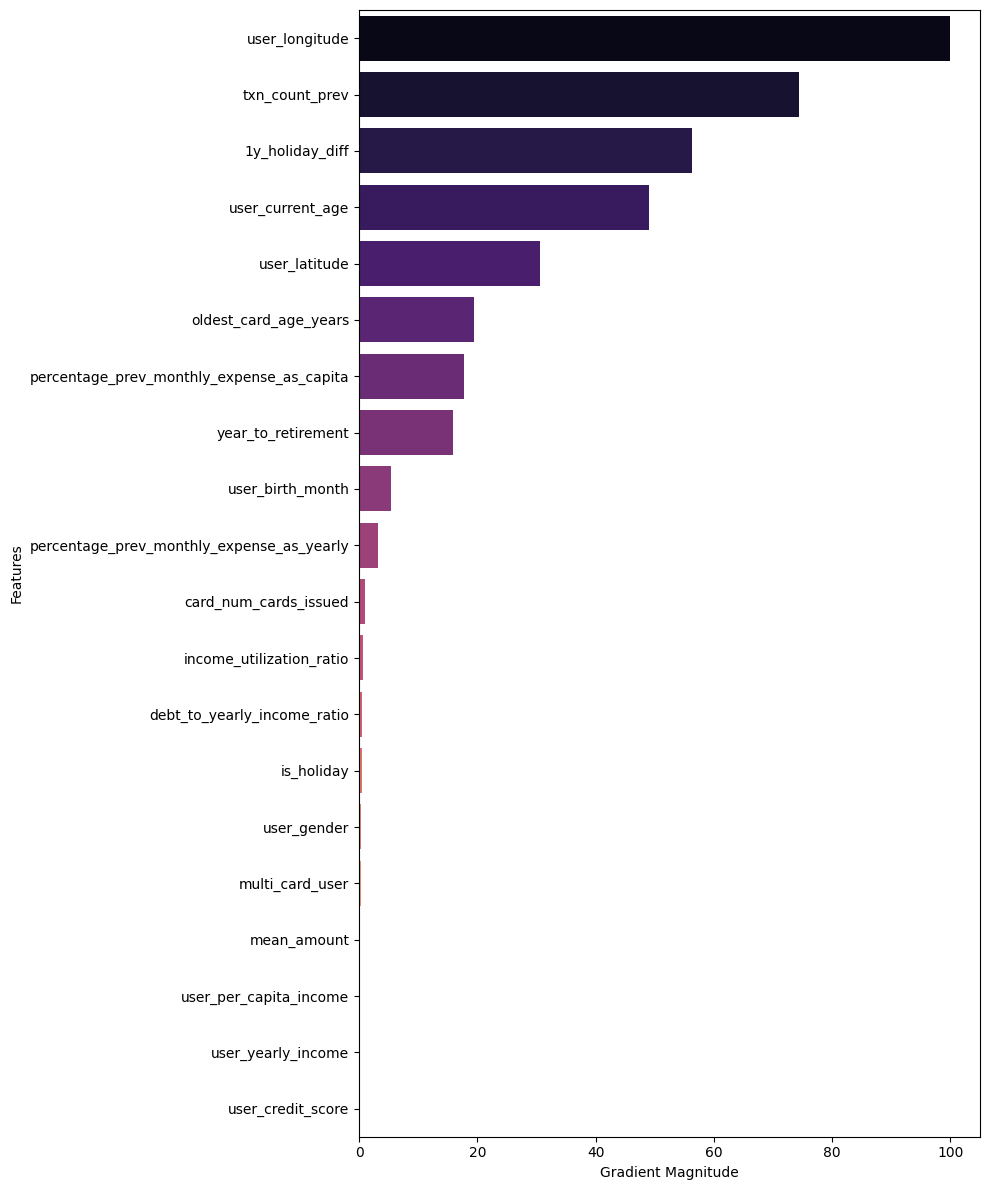

                                      Feature  Importance  Relative Importance
11                             user_longitude    0.000419           100.000000
0                              txn_count_prev    0.000312            74.423889
21                            1y_holiday_diff    0.000236            56.360245
3                            user_current_age    0.000205            48.982014
10                              user_latitude    0.000128            30.568924
18                      oldest_card_age_years    0.000082            19.436573
20  percentage_prev_monthly_expense_as_capita    0.000074            17.672915
12                         year_to_retirement    0.000066            15.841704
8                            user_birth_month    0.000023             5.454372
19  percentage_prev_monthly_expense_as_yearly    0.000013             3.135298


In [ ]:
from captum.attr import IntegratedGradients
import seaborn as sns

def calculate_ig_importance(model, loader, feature_names, device):
    """
    How much did this feature contribute to the predicted dollar amount?"
    """
    model.eval()
    cudnn_enabled_orig = torch.backends.cudnn.enabled
    torch.backends.cudnn.enabled = False
    
    try:
        ig = IntegratedGradients(model)
        X_batch, _ = next(iter(loader))
        X_batch = X_batch.to(device)
        attributions, _ = ig.attribute(inputs=X_batch, return_convergence_delta=True)
        importances = torch.mean(torch.abs(attributions), dim=0).sum(dim=0)
        importances = importances.detach().cpu().numpy()
        
        importance_df = pd.DataFrame({'Feature': feature_names,'Importance': importances})

        importance_df['Relative Importance'] = importance_df['Importance'] / importance_df['Importance'].max() * 100
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        
        return importance_df
        
    finally:
        torch.backends.cudnn.enabled = cudnn_enabled_orig


ig_importance_df = calculate_ig_importance(model, val_loader, feature_cols, device)

plt.figure(figsize=(10, 12))
sns.barplot(x="Relative Importance", y="Feature", data=ig_importance_df.head(20), palette="magma")
plt.xlabel("Gradient Magnitude")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

print(ig_importance_df.head(10))

-- Location is the key
-- User behaviors like spend frequency is important
-- User's age is also important to contribute the output(predicted dollar amount)